In [1]:
import re
import string
import nltk
from nltk.stem import WordNetLemmatizer
import pickle as pk
import gensim
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import pandas as pd

from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score  

from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Embedding,Input,BatchNormalization,Dense,Bidirectional,LSTM,Dropout
from keras.callbacks import History ,ModelCheckpoint, EarlyStopping
from keras.layers.merge import add, dot, concatenate, multiply, average
from nltk.stem import *
from nltk import word_tokenize


%matplotlib inline
%env CUDA_VISIBLE_DEVICES=0

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


env: CUDA_VISIBLE_DEVICES=0


## Load Data

In [40]:
LabelsMapping = {'Other': 0,
                 'Message-Topic(e1,e2)': 1, 'Message-Topic(e2,e1)': 2,
                 'Product-Producer(e1,e2)': 3, 'Product-Producer(e2,e1)': 4,
                 'Instrument-Agency(e1,e2)': 5, 'Instrument-Agency(e2,e1)': 6,
                 'Entity-Destination(e1,e2)': 7, 'Entity-Destination(e2,e1)': 8,
                 'Cause-Effect(e1,e2)': 9, 'Cause-Effect(e2,e1)': 10,
                 'Component-Whole(e1,e2)': 11, 'Component-Whole(e2,e1)': 12,
                 'Entity-Origin(e1,e2)': 13, 'Entity-Origin(e2,e1)': 14,
                 'Member-Collection(e1,e2)': 15, 'Member-Collection(e2,e1)': 16,
                 'Content-Container(e1,e2)': 17, 'Content-Container(e2,e1)': 18}

def _shuffle(X, feature1, feature2, y):
    randomize = np.arange(len(X))
    np.random.shuffle(randomize)
    return (X[randomize], feature1[randomize], feature2[randomize], y[randomize])

def load_data(FILE_Path):
    otuput_sent = []
    lemmatizer = WordNetLemmatizer()
    with open(FILE_Path, "r") as f:
        train_tmp = f.read().split("\n\n")[:-1]
        for sample in train_tmp:
            sentence = re.split('\t|\n', sample)[1].replace('\"',"").replace(".","").replace(",","")\
            .replace("?","").replace("!","").replace(")","").replace("(","").replace("\'s","")\
            .replace("\'ve","").replace("\'t","").replace("\'re","").replace("\'d","").replace("\'ll","")
            answer = re.split('\t|\n', sample)[2]
            soup = BeautifulSoup(sentence,"lxml")

            e1 = str(soup.find('e1'))[4:-5]
            e2 = str(soup.find('e2'))[4:-5]
            word_list = sentence.split(" ")
            for word in word_list:
                if "</e1>" in word:
                    a = word
                if "</e2>" in word:
                    b = word
            p1 = word_list.index(a)
            p2 = word_list.index(b)
            sentence = sentence.replace("<e1>","").replace("</e1>","").replace("<e2>","").\
            replace("</e2>","")
#             sentence = [lemmatizer.lemmatize(word, pos='v') for word in sentence.split(" ")]
#             sentence = " ".join(sentence)
            otuput_sent.append((sentence,e1,e2,p1,p2,answer))
    return otuput_sent

In [41]:
train_instance = load_data('./data/TRAIN_FILE.txt')
test_instance = load_data('./data/TEST_FILE_FULL.txt')
# sentence_list = train_sentence + test_sentence
print("number of training instances:", len(train_instance))
print("number of testing instances:", len(test_instance))
# tuple format: (text, e1, e2, pos1, pos2, answer)

number of training instances: 8000
number of testing instances: 2717


In [42]:
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

num_classes = 19
train_text = []
for instance in train_instance:
    p1 = instance[3]
    p2 = instance[4]
    split_sentence = instance[0].split(" ")
    p1_mod = max(0,p1-3)
    p2_mod = min(len(split_sentence), p2+3)
    prune_text = " ".join(split_sentence[p1:p2+1])
    train_text.append(prune_text)

train_label = [LabelsMapping[ele[5]] for ele in train_instance]
train_label = dense_to_one_hot(np.array(train_label), 19)

test_text = []
for instance in test_instance:
    p1 = instance[3]
    p2 = instance[4]
    split_sentence = instance[0].split(" ")
    p1_mod = max(0,p1-3)
    p2_mod = min(len(split_sentence), p2+3)
    prune_text = " ".join(split_sentence[p1:p2+1])
    test_text.append(prune_text)
    
test_label = [LabelsMapping[ele[5]] for ele in test_instance]
test_label = dense_to_one_hot(np.array(test_label), 19)

total_text = train_text + test_text

In [43]:
train_mut_ancestors_list = np.load("./features/train_mut_ancestors_list.npy")
test_mut_ancestors_list = np.load("./features/test_mut_ancestors_list.npy")

In [44]:
train_dep_list = np.load("./features/train_dep_list.npy")
test_dep_list = np.load("./features/test_dep_list.npy")

## Tokenizer

In [45]:
tokenizer = Tokenizer(num_words=25000,lower=True,split=' ',char_level=False)
tokenizer.fit_on_texts(total_text)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 11518 unique tokens.


In [46]:
train_sentence_seq = tokenizer.texts_to_sequences(train_text)
test_sentence_seq = tokenizer.texts_to_sequences(test_text)

max_length = np.max([len(i) for i in train_sentence_seq+test_sentence_seq])
print("max length:", max_length)

x_train_seq = sequence.pad_sequences(train_sentence_seq, maxlen=max_length)
x_test_seq = sequence.pad_sequences(test_sentence_seq, maxlen=max_length)

max length: 33


## Build embedding_matrix

In [13]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
# download pre-trained word vector from "https://nlp.stanford.edu/projects/glove/"
tmp_file = get_tmpfile("/home/thtang/LifeLog/data/glove_pretrained/gensim_crawl_300d.txt")

w2vModel = KeyedVectors.load_word2vec_format(tmp_file)

In [47]:
# prepare embedding matrix
embedding_size = 300
num_words = len(word_index)+1
embedding_matrix = np.zeros((num_words, embedding_size))
oov = 0
for word, i in word_index.items():
    if word in w2vModel.wv.vocab:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = w2vModel[word]
    else:
        oov+=1
print("OOV:",oov)

OOV: 218


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


In [52]:
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Embedding, Input,InputLayer,BatchNormalization, Dense, Bidirectional,LSTM,Dropout,GRU,Activation
from keras import backend as K
def swish(x):
    return (K.sigmoid(x) * x)
get_custom_objects().update({'swish': Activation(swish)})

def train_BiLSTM(x_train, ancestor_train, dep_train, y_train, 
                 x_val, ancestor_val, dep_val, y_val,
                 embedding_matrix, max_length, max_features):
    embedding_size = 300
    batch_size = 64
    epochs = 50
    embedding_layer = Embedding(max_features,output_dim= embedding_size,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)
    sequence_input = Input(shape=(max_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    lstm0 = Bidirectional(LSTM(256,activation="tanh",dropout=0.2,return_sequences = True,
                kernel_initializer='he_uniform'))(embedded_sequences)
    lstm1 = Bidirectional(LSTM(128,activation="tanh",dropout=0.2,return_sequences = True,
                kernel_initializer='he_uniform'))(lstm0)
    lstm2 = Bidirectional(LSTM(64,activation="tanh",dropout=0.2,return_sequences = False,
                kernel_initializer='he_uniform'))(lstm1)
    bn1 = BatchNormalization()(lstm2)
    
    # other feature inputs 
    ancestor_input = Input(shape=(2,))
    ancestor_feature = Dense(64, activation=swish)(ancestor_input)
    
    
    dep_input = Input(shape=(34,))
    dep_feature = Dense(128, activation=swish)(dep_input)
    
    combine_feature = concatenate([bn1, ancestor_feature, dep_feature])
    dense1 = Dense(64, activation=swish)(combine_feature)
    dropout1 = Dropout(0.5)(dense1)
    dense2 = Dense(32, activation=swish)(dropout1)
    dropout2 = Dropout(0.5)(dense2)
    preds = Dense(19, activation='softmax')(dropout2)
    model = Model([sequence_input, ancestor_input, dep_input], preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    filepath = "models/BiLSTM_3.hdf5" 
    checkpoint = ModelCheckpoint(filepath,monitor='val_acc',save_best_only=True)
    history = History()
    callbacks_list = [checkpoint, history]
    
    history = model.fit([x_train, ancestor_train, dep_train], y_train, 
                        validation_data=([x_val, ancestor_val, dep_val], y_val), 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        callbacks=callbacks_list)
    return model, history

In [53]:
train_X, train_ancestor, train_dep, train_y = _shuffle(x_train_seq, 
                                                       train_mut_ancestors_list,
                                                       train_dep_list,
                                                       train_label)
model, history = train_BiLSTM(train_X, train_ancestor, train_dep, train_y, 
                     x_test_seq, test_mut_ancestors_list, test_dep_list, test_label,
                     embedding_matrix,
                     max_length,
                     len(word_index)+1)

Train on 8000 samples, validate on 2717 samples
Epoch 1/50
8000/8000 [==============================] - 45s 6ms/step - loss: 2.4330 - acc: 0.2659 - val_loss: 1.5594 - val_acc: 0.5661
Epoch 2/50
8000/8000 [==============================] - 40s 5ms/step - loss: 1.8317 - acc: 0.4537 - val_loss: 1.2437 - val_acc: 0.6526
Epoch 3/50
8000/8000 [==============================] - 41s 5ms/step - loss: 1.5340 - acc: 0.5524 - val_loss: 1.0930 - val_acc: 0.6908
Epoch 4/50
8000/8000 [==============================] - 42s 5ms/step - loss: 1.3697 - acc: 0.6089 - val_loss: 1.0420 - val_acc: 0.6975
Epoch 5/50
8000/8000 [==============================] - 42s 5ms/step - loss: 1.2228 - acc: 0.6491 - val_loss: 0.9681 - val_acc: 0.7247
Epoch 6/50
8000/8000 [==============================] - 41s 5ms/step - loss: 1.1147 - acc: 0.6824 - val_loss: 0.9847 - val_acc: 0.7310
Epoch 7/50
8000/8000 [==============================] - 43s 5ms/step - loss: 1.0115 - acc: 0.7111 - val_loss: 0.8901 - val_acc: 0.7516
Epoch 8

## Testing

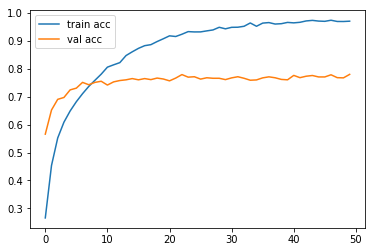

In [61]:
train_acc = history.history["acc"]
val_acc = history.history["val_acc"]
plt.plot(train_acc, label="train acc")
plt.plot(val_acc, label="val acc")
plt.legend()
plt.show()

In [62]:
y_test = [np.where(r==1)[0][0] for r in test_label ]

# model_name = ['models/BiLSTM_0817.hdf5','models/BiLSTM_08175.hdf5',
#               'models/BiLSTM_0820.hdf5','models/BiLSTM_0821.hdf5']

# model1 = load_model(model_name[0])
# prediction1 = model1.predict([x_test_seq], batch_size=1000)
# model2 = load_model(model_name[1])
# prediction2 = model2.predict([x_test_seq,test_mut_ancestors_list,test_dep_list], batch_size=1000)
# model3 = load_model(model_name[2])
# prediction3 = model3.predict([x_test_seq,test_mut_ancestors_list,test_dep_list], batch_size=1000)
# model4 = load_model(model_name[3])
# prediction4 = model4.predict([x_test_seq,test_mut_ancestors_list], batch_size=1000)

# model = load_model("./models/BiLSTM_3.hdf5")
prediction = model.predict([x_test_seq,test_mut_ancestors_list,test_dep_list], batch_size=1000)


# prediction_list = []
# for path in model_name:
#     model = load_model(path)
#     prediction = model.predict([x_test_seq,test_mut_ancestors_list,test_dep_list], batch_size=1000)
#     prediction_list.append(prediction)


In [ ]:
prediction_total = prediction1 + prediction2 + prediction3 + prediction4

In [63]:
pred_y = np.argmax(prediction,axis=1)
print("accuracy:",accuracy_score(pred_y.tolist(), y_test)) 

accuracy: 0.7802723592197276


In [64]:
LabelsMapping_inv =  {v: k for k, v in LabelsMapping.items()}

In [65]:
pred_y = [LabelsMapping_inv[v] for v in pred_y]

In [66]:
test_id = list(range(8001,8001+len(pred_y)))

In [67]:
with open("proposed_answers.txt", "w") as f:
    for i in range(len(test_id)):
        f.write(str(test_id[i])+"\t"+pred_y[i])
        f.write("\n")

Then run the judgement

In [ ]:
# model_name = ['models/BiLSTM_0817.hdf5','models/BiLSTM_08175.hdf5',
#               'models/BiLSTM_0820.hdf5','models/BiLSTM_0821.hdf5']

Micro-averaged result (excluding Other):
P = 1956/2367 =  82.64%     R = 1956/2263 =  86.43%     F1 =  84.49%

MACRO-averaged result (excluding Other):
P =  82.12%     R =  85.90%     F1 =  83.89%
